In [1]:

import sys
sys.path.append("../")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cvx
from matrix_algorithms.difference_matrix import Difference_Matrix



In [556]:
def fused_lasso(D_k_beta_u,alpha,n,k,lambda_,rho):
    """Fused Lasso Wrapper Adapted to ADMM"""
    
    # feature matrix is identity matrix
    X=np.eye(n-k-1)

    # cvxpy variables
    alpha_hat = cvx.Variable(n-k-1)
    alpha_hat.value = alpha.flatten()

    
    # forward difference matrix
    forwardDiff = alpha_hat[k:] - alpha_hat[0:-k]

    # fused lasso objective of mse + lambda/rho*norm
    objective = cvx.Minimize(.5*cvx.sum_squares(X@alpha_hat - D_k_beta_u) + lambda_/rho*cvx.norm(forwardDiff,1))
 
    prob = cvx.Problem(objective)
    
    result = prob.solve(warm_start=True)

  

    return alpha_hat.value.reshape(-1,1)



In [557]:
def specialized_admm(y: np.ndarray, k: int , lambda_: float):
    """Specialized ADMM Implementation for Trend Filtering

    """

    # construct difference matrix
    n = y.shape[0]
    y=y.reshape(-1,1)
    D = Difference_Matrix(n, k=k)
    D_ = D.D
    D_t_D = D_.T.dot(D_)


   # set max iterations
    MAX_ITER = 250

    # initialize variables with guesses
    beta = y.copy()
    alpha = D.D.dot(beta)
    u = np.zeros([n-k-1, 1])

    
    # ref. sets rho to lambda for stability
    rho=lambda_

    # Pre-compute to save some multiplications
    I = np.identity(n)
    rho_D_T= rho * D_.T
    Q = I + rho * D_t_D
    Q_inv = np.linalg.inv(Q)
    Q_inv_dot = Q_inv.dot

    # Calculate lambda_max
    D_k_1=Difference_Matrix(n, k=k+1)
    lambda_max= np.amax(np.absolute(np.linalg.inv(D_k_1.D.dot(D_k_1.D.T)).dot((D_k_1.D).dot(y))))

   

    for _ in range(MAX_ITER):

        # beta is in R^{n x 1}
        beta = Q_inv_dot(y+ rho_D_T.dot((alpha + u).reshape(-1,1 )))
      
        # alpha is in R^{n-k-1 x 1}
       # try:
            
            # precompute observation matrix
        D_k_beta_u=(D.D@beta-u).flatten()
        alpha = fused_lasso(D_k_beta_u,alpha,D.n,D.k,lambda_,rho)
            
            # update u
        u = u + alpha - D_.dot(beta)

        # except Exception as e:
        #     print(e)
        #     break
            
    return beta


### Prep ADMM Implementation for TF Problem

Note the 

In [558]:
from matrix_algorithms.difference_matrix import Difference_Matrix

from trend_filtering.continous_tf import Continous_TF

PATH = "../../../taq_db/TAQ-Query-Scripts/data/features/2020-01-02/"
sys.path.append(PATH)
DATA_FILE = "AMZN_reconstructed_features.csv"


In [559]:
market_data = pd.read_csv(PATH + DATA_FILE, index_col=0, nrows=20000)
market_data.index = pd.to_datetime(market_data.index)

trade_data= market_data[market_data["Trade_Volume"] > 0]

regular_trades = trade_data[trade_data["Sale_Condition"] == "@   "]
regular_trades.head()

,Date,Exchange,Symbol,Trade_Volume,Trade_Price,Sale_Condition,Source_of_Trade,Trade_Correction_Indicator,Sequence_Number,Trade_Id,...,YearMonth,Imbalance,MOX_Identifier,Effective_Spread,Microprice,Imbalance_Weighted_Effective_Spread,Price_Impact,Realized_Spread,Midprice,Trade_Side
index,,,,,,,,,,,,,,,,,,,,,
2020-01-02 09:30:00.820,2020-01-02,D,AMZN,100.0,1874.5450,@,N,0.0,21402,140.0,...,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24389,191.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:00.948,2020-01-02,D,AMZN,100.0,1874.7425,@,N,0.0,24286,185.0,...,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.040,2020-01-02,D,AMZN,100.0,1874.7400,@,N,0.0,24778,233.0,...,NaN,NaN,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 09:30:01.160,2020-01-02,D,AMZN,200.0,1874.9900,@,N,0.0,26914,252.0,...,NaN,NaN,151.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [560]:
trade_price=regular_trades["Trade_Price"].values
trade_price=trade_price.reshape(-1,1)

In [561]:
beta_low=specialized_admm(trade_price,k=1,lambda_=50)

beta_high=specialized_admm(trade_price,k=1,lambda_=250)


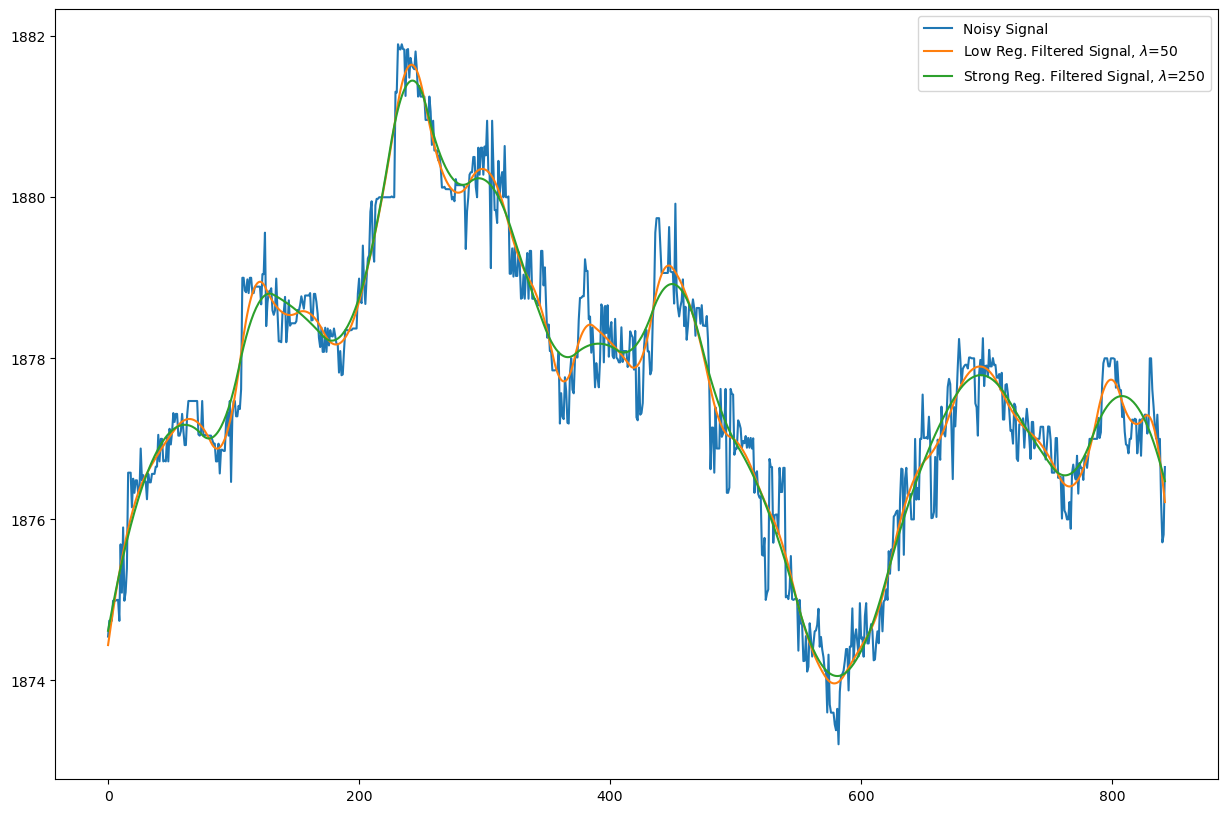

In [537]:
fig,ax=plt.subplots(figsize=(15,10))

ax.plot(trade_price,label="Noisy Signal")
ax.plot(beta_low,label=f"Low Reg. Filtered Signal, $\lambda$={50}")
ax.plot(beta_high,label=f"Strong Reg. Filtered Signal, $\lambda$={250}")
ax.legend()

In [339]:
def tf_admm(beta:np.ndarray,D:Difference_Matrix,y:np.ndarray):
    
    f_hat=Continous_TF(y,D=D,k=D.k,theta=beta.reshape(-1,1))
    
    t=D.t if D.t is not None else np.arange(D.n)
    estimate=f_hat.evaluate_tf(t)

    return estimate,f_hat
    

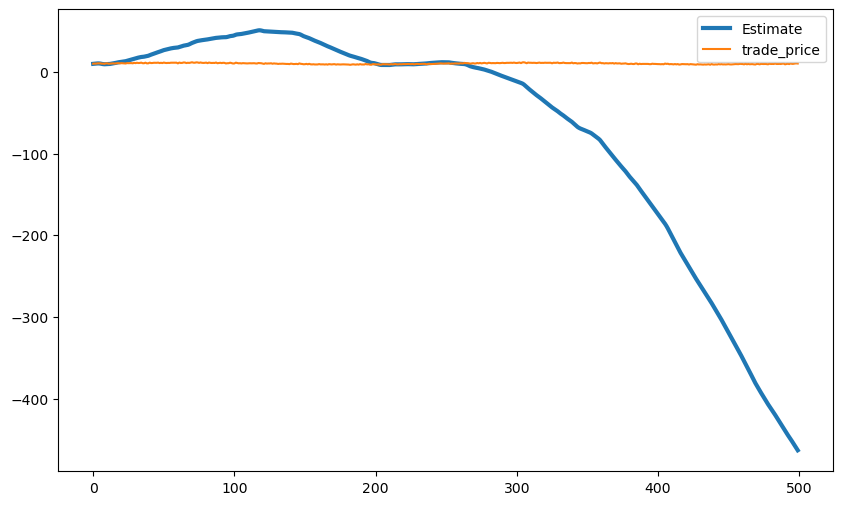

In [ ]:
beta=ADMM(D.D,noisy_signal,1)


estimate,f_hat=tf_admm(beta,D,noisy_signal)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(estimate, label="Estimate",lw=3)
ax.plot(noisy_signal, label="trade_price")


ax.legend(loc="upper right")


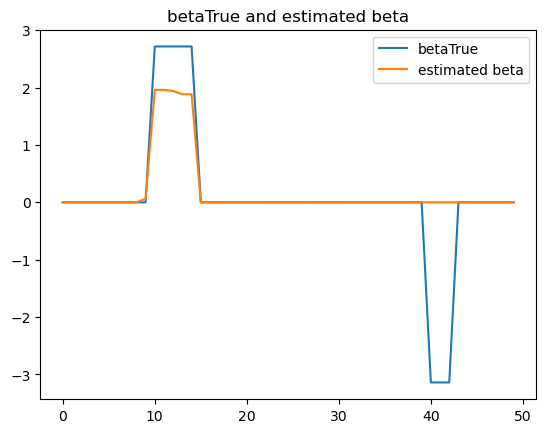

In [99]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

# First create some fake data.
m = 30
n = 50

betaTrue = np.zeros(n)
betaTrue[10:15] = 2.718
betaTrue[40:43] = -3.14159

np.random.seed(1)
X = np.random.randn(m, n)
noise = 0.01*np.random.randn(m)
y = X@betaTrue + noise 

# Now set regularization parameter values. 
lmbda = 10.0
gamma = 25.0

# Here's the part of the code where we use cvxpy to
# solve our fused Lasso problem.
beta = cp.Variable(n)
forwardDiff = beta[1:] - beta[0:-1]
objective = cp.Minimize(.5*cp.sum_squares(X@beta - y) + lmbda*cp.norm(beta,1) + gamma*cp.norm(forwardDiff,1))
constraints = [0 <= beta]
prob = cp.Problem(objective, constraints)
result = prob.solve()

# Plot the true and estimated beta vectors.
plt.figure()
plt.plot(betaTrue)
plt.plot(beta.value)
plt.title('betaTrue and estimated beta')
plt.legend(['betaTrue','estimated beta'])
plt.show()